### 8. Parameter Fitting


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

Read and process data

In [6]:
galcuts = ['10']
freq_auto = ['23']

cl_auto = np.zeros([len(galcuts), len(freq_auto), 7, 102])
error_auto = np.zeros([len(galcuts), len(freq_auto), 7, 102])

# Read data
for ii in range(len(galcuts)):
    for jj in range(len(freq_auto)):
        cl_auto[ii,jj] = np.loadtxt('../results/spectra/cl_' + freq_auto[jj] + 'ghz_galcut' + galcuts[ii] + '.txt', skiprows=1)
        error_auto[ii,jj] = np.loadtxt('../results/errorbars/errorbar_' + freq_auto[jj] + 'ghz_galcut' + galcuts[ii] + '.txt', skiprows=1)

# Trim data up to resolution of interest (l=300)
ell = cl_auto[0,0,0, 3:30]

cl_ee_galcut_10 = cl_auto[0, 0, 2, 3:30]
cl_bb_galcut_10 = cl_auto[0, 0, 3, 3:30]

error_ee_galcut_10 = error_auto[0, 0, 2, 3:30]
error_bb_galcut_10 = error_auto[0, 0, 3, 3:30]

Define the model to be fit, and likelihood and prior of MCMC 

In [9]:
def model(theta, ell=ell):
    A, alpha, c = theta
    return A * 1e-9 * (ell/80)**alpha + c * 1e-9

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta)) / yerr)**2)

def lnprior(theta):
    A, alpha, c = theta
    if -6 < alpha < -0.5: # and c > 0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    # If the parameter is not within the priors, return a -infinite
    if not np.isfinite(lp): 
        return -np.inf
    # if theta fulfills the priors, then lp = 0
    return lp + lnlike(theta, x, y, yerr) 


def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    # Run 100 iterations for each initial position
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True) 
    sampler.reset()

    print("Running production...")
    # Run niter iterations with the new initial positions
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True) 

    return sampler, pos, prob, state  

Set walkers, iterations and initial parameters

In [10]:
nwalkers = 100
niter = 10000
ndim = 3 # Number of inidependent parameters (A, alpha, c)
discard_frac = 0.5
initial = [45., -3., 0.]
variations = np.array([1e-1, 1e-1, 1e-1])

p0 = [np.array(initial) + variations * np.random.randn(ndim) for i in range(nwalkers)]

Run chains

In [11]:
data_ee = [ell, cl_ee_galcut_10, error_ee_galcut_10]
data_bb = [ell, cl_bb_galcut_10, error_bb_galcut_10]


sampler_ee, _, _, _ = main(p0, nwalkers, niter, ndim, lnprob, data_ee)
sampler_bb, _, _, _ = main(p0, nwalkers, niter, ndim, lnprob, data_bb)

samples_ee = sampler_ee.get_chain(flat=True, thin=10, discard = int(discard_frac * niter))  
samples_bb = sampler_bb.get_chain(flat=True, thin=10, discard = int(discard_frac * niter))  

labels = ['A', 'alpha', 'c']

Running burn-in...


100%|██████████| 100/100 [00:00<00:00, 594.62it/s]

Running production...



100%|██████████| 10000/10000 [00:14<00:00, 706.24it/s]


Running burn-in...


100%|██████████| 100/100 [00:00<00:00, 694.23it/s]


Running production...


100%|██████████| 10000/10000 [00:15<00:00, 647.39it/s]


Corner Plots of parameters

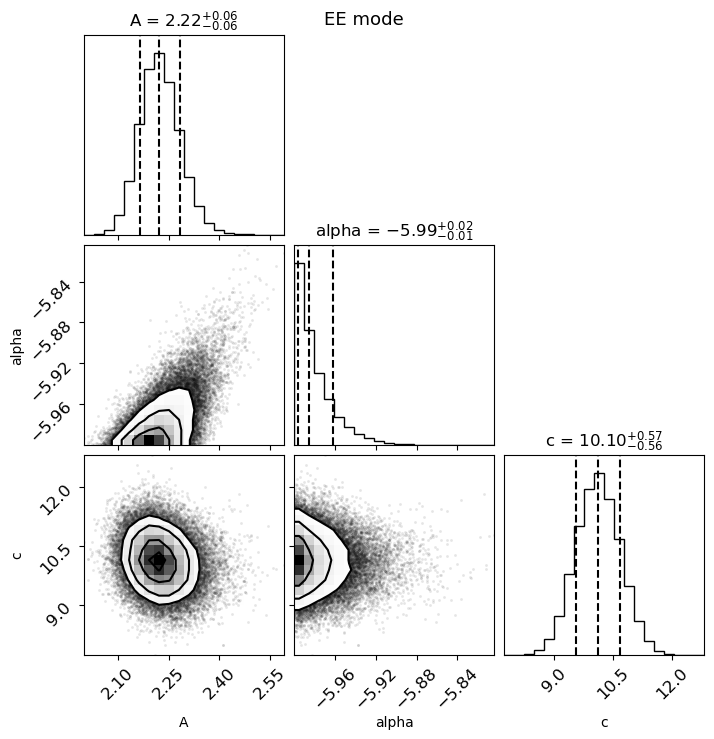

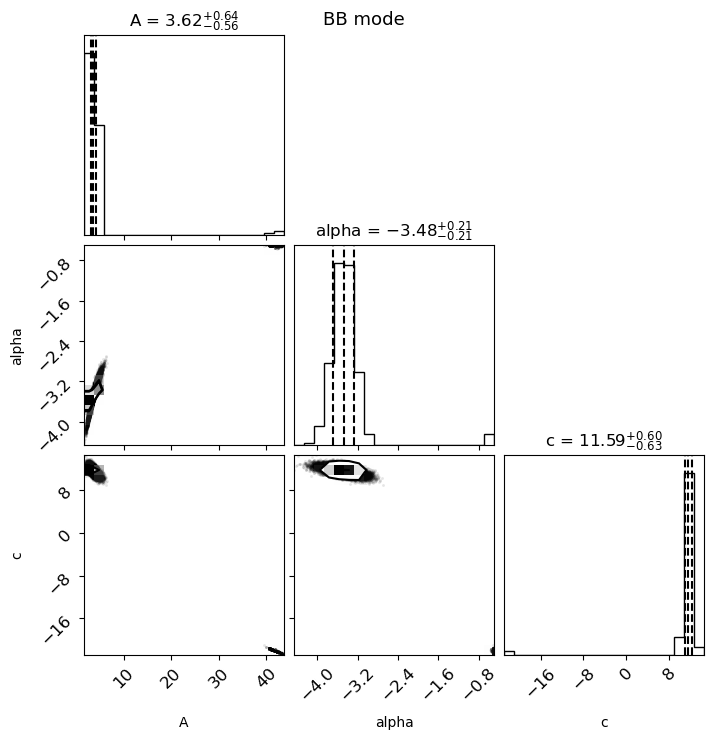

In [15]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = [16, 9]

corner_ee = corner.corner(samples_ee, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
corner_ee.suptitle('EE mode', fontsize=13)
plt.show()

corner_bb = corner.corner(samples_bb, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84])
corner_bb.suptitle('BB mode', fontsize=13)
plt.show()

corner_ee.savefig('../figures/corner_plot_mcmc_ee.pdf')
corner_bb.savefig('../figures/corner_plot_mcmc_bb.pdf')

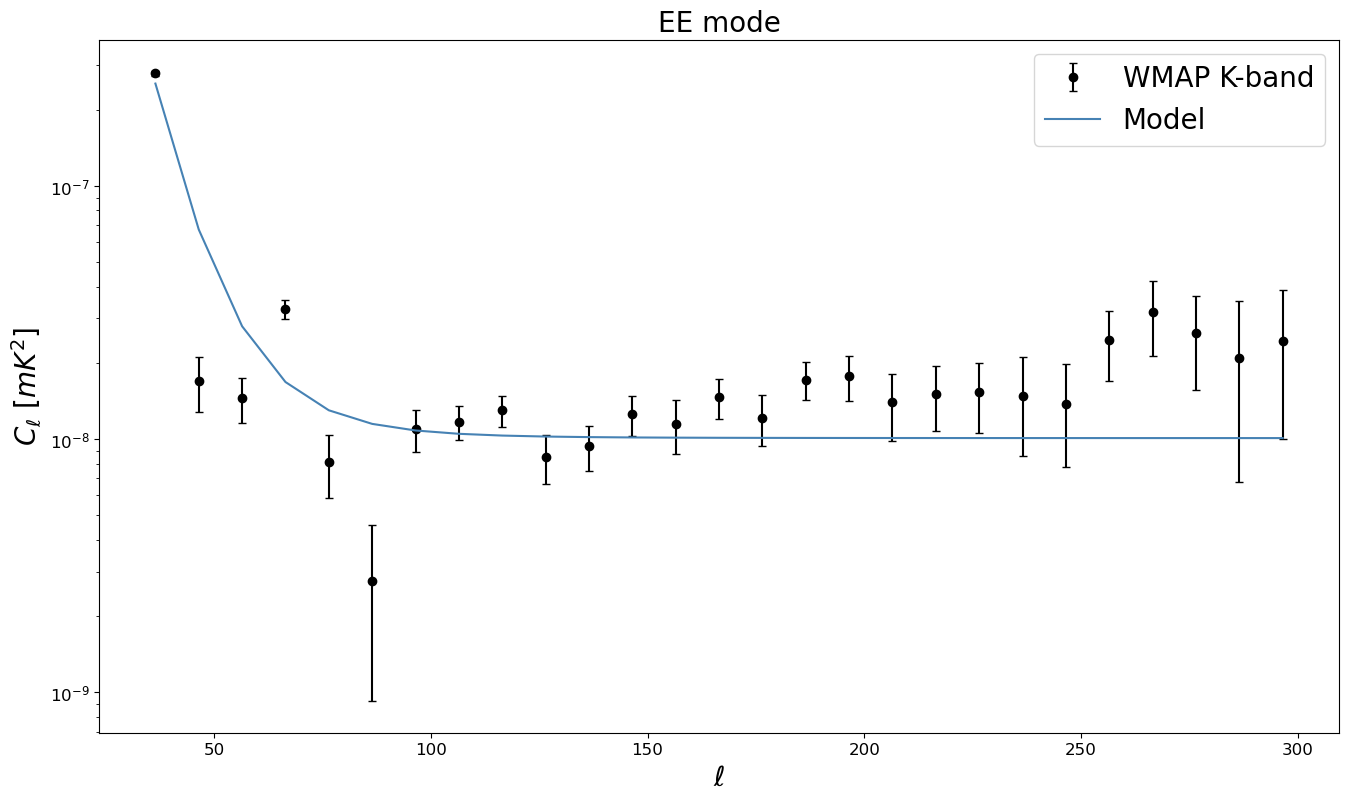

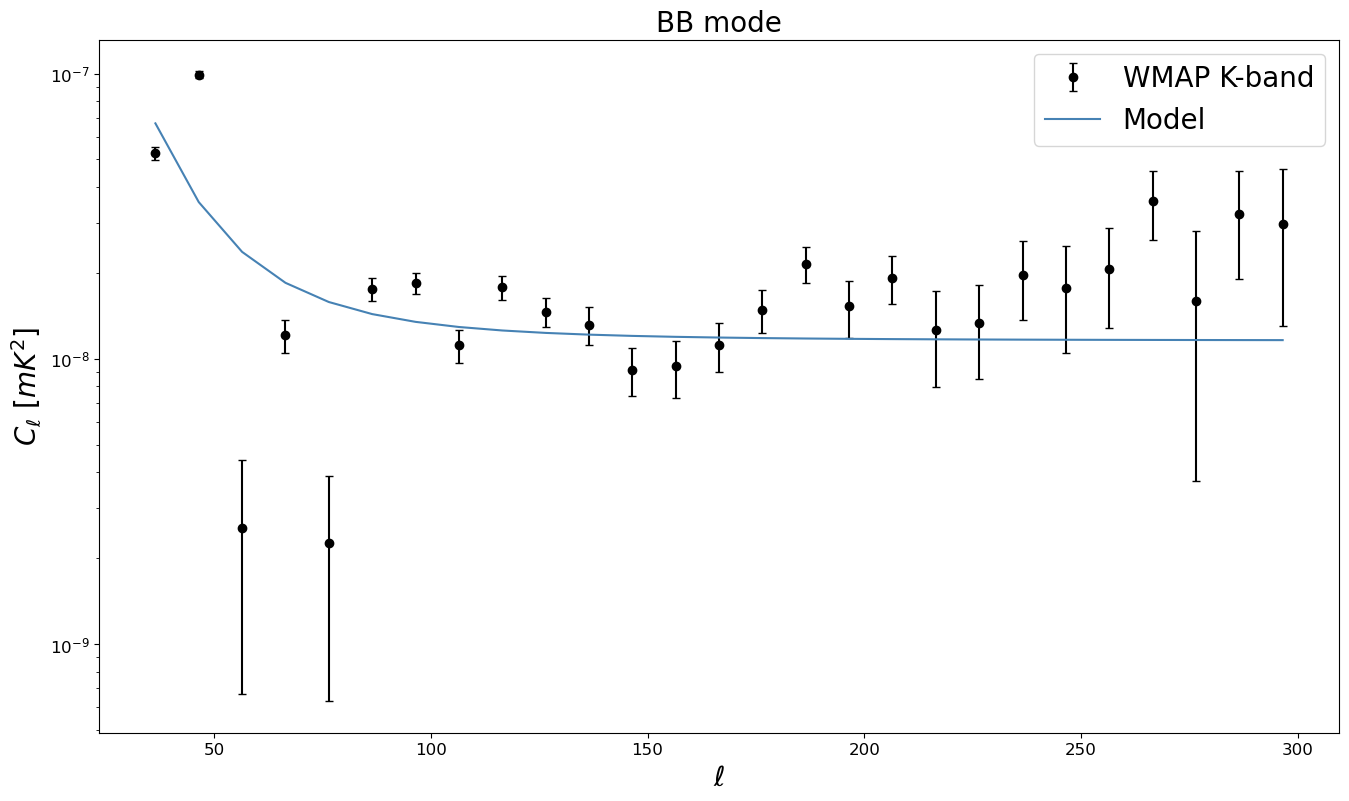

In [16]:
results_ee = np.percentile(samples_ee, [16, 50, 84], axis=0).T
results_bb = np.percentile(samples_bb, [16, 50, 84], axis=0).T

fig_ee = plt.figure()
plt.errorbar(ell, cl_ee_galcut_10, yerr=error_ee_galcut_10, fmt='o', color='k', capsize=3, label='WMAP K-band')
plt.errorbar(ell, model(results_ee[:, 1]), color='steelblue', label='Model')
plt.yscale('log'), plt.title('EE mode', fontsize=20)
plt.ylabel('$C_{\ell} \ [mK^2]$', fontsize=20), plt.xlabel('$\ell$', fontsize=20)
plt.legend(fontsize=20), plt.show()

fig_bb = plt.figure()
plt.errorbar(ell, cl_bb_galcut_10, yerr=error_bb_galcut_10, fmt='o', color='k', capsize=3, label='WMAP K-band')
plt.errorbar(ell, model(results_bb[:, 1]), color='steelblue', label='Model')
plt.yscale('log'), plt.title('BB mode', fontsize=20)
plt.ylabel('$C_{\ell} \ [mK^2]$', fontsize=20), plt.xlabel('$\ell$', fontsize=20)
plt.legend(fontsize=20), plt.show()

fig_ee.savefig('../figures/cl_fitted_model_ee.pdf')
fig_bb.savefig('../figures/cl_fitted_model_bb.pdf')